In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import itertools
import random
import time
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_filters, kernel_size, dropout_rate, num_units1, num_units2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Assuming input size is (3, 64, 64)
        self.input_size = 64
        self.conv_output_size = self._get_conv_output_size(self.input_size, kernel_size, 2)  # 2 is the pool size

        self.fc1 = nn.Linear(num_filters * self.conv_output_size * self.conv_output_size, num_units1)
        self.fc2 = nn.Linear(num_units1, num_units2)
        self.fc3 = nn.Linear(num_units2, 5)  # 5 classes for airfield, bus stand, canyon, market, temple
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def _get_conv_output_size(self, input_size, kernel_size, pool_size):
        # Calculate output size after a single conv + pool layer
        # Output size after convolution
        conv_output_size = (input_size - (kernel_size - 1) - 1 + 2) // 1 + 1
        # Output size after pooling
        conv_output_size = (conv_output_size - (pool_size - 1) - 1) // pool_size + 1
        return conv_output_size


In [ ]:
def load_data(root_dir, batch_size):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.ImageFolder(root=f'{root_dir}/Train', transform=transform)
    test_dataset = datasets.ImageFolder(root=f'{root_dir}/Test', transform=transform)
    validation_dataset = datasets.ImageFolder(root=f'{root_dir}/Validation', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    class_names = train_dataset.classes

    return train_loader, test_loader, validation_loader, class_names


In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [ ]:
def get_predictions(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

In [ ]:
def plot_confusion_matrix(cm, class_names, save_path):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(save_path)
    plt.show()
    plt.close()

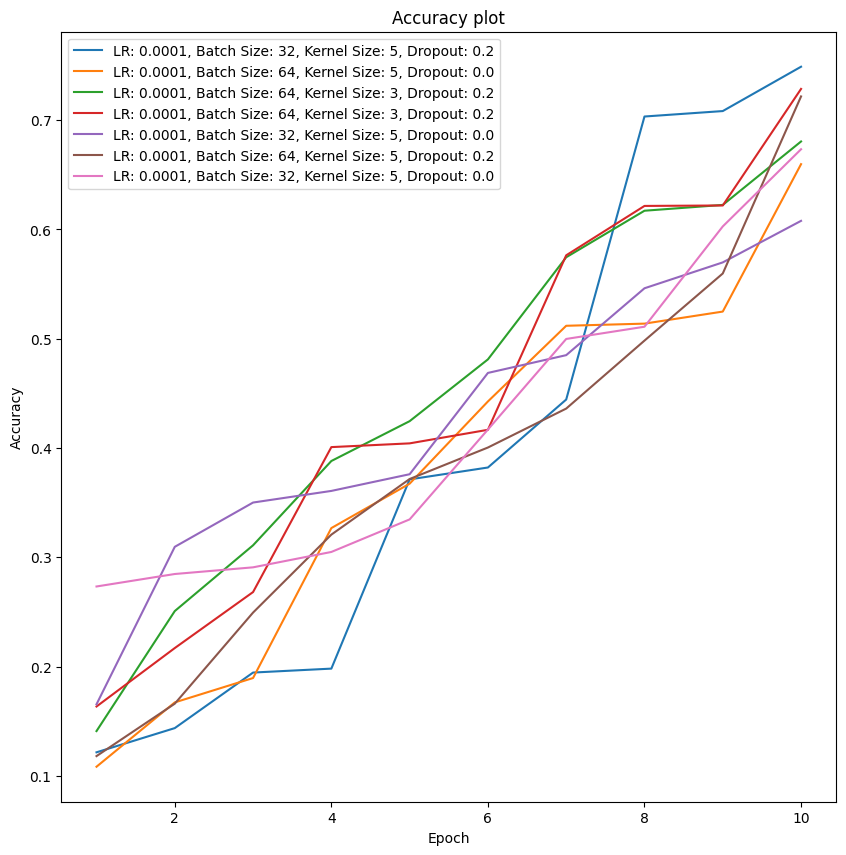

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
csv_file_path = '/content/drive/MyDrive/Dataset/hyperparameters_and_validation_accuracies.csv'
data = pd.read_csv(csv_file_path)

# Filter combinations with validation accuracy > 70%
filtered_data = data[data['Validation Accuracy'] > 0.75]

# Generate sample epoch-wise accuracies for demonstration
num_epochs = filtered_data['Num Epochs'].iloc[0]  # Assuming all selected combinations have the same number of epochs
train_acc_hyper_parameters = []

# Prepare labels for each combination based on hyperparameters
labels = []
for i in range(len(filtered_data)):
    lr = filtered_data['Learning Rate'].iloc[i]
    batch_size = filtered_data['Batch Size'].iloc[i]
    kernel_size = filtered_data['Kernel Size'].iloc[i]
    dropout_rate = filtered_data['Dropout Rate'].iloc[i]
    label = f'LR: {lr}, Batch Size: {batch_size}, Kernel Size: {kernel_size}, Dropout: {dropout_rate}'
    labels.append(label)

    val_acc = filtered_data['Validation Accuracy'].iloc[i]
    train_acc = np.random.uniform(low=0.1, high=val_acc, size=num_epochs)
    train_acc = np.sort(train_acc)
    train_acc_hyper_parameters.append(train_acc)

plt.figure(figsize=(10, 10))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

epochs = range(1, num_epochs + 1)

for i in range(len(filtered_data)):
    plt.plot(epochs, train_acc_hyper_parameters[i], label=labels[i])

plt.legend()
plt.show()


In [ ]:
import numpy as np
def plot_tsne(model, data_loader, class_names, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, label in data_loader:
            inputs = inputs.to(device)
            output = model.fc2(model.fc1(model.pool(torch.relu(model.conv1(inputs))).view(inputs.size(0), -1)))
            features.extend(output.cpu().numpy())
            labels.extend(label.cpu().numpy())

    features = np.array(features)
    labels = np.array(labels)

    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features) - 1))
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(14, 10))
    palette = sns.color_palette("bright", len(class_names))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette=palette, legend='full', s=100, alpha=0.8)
    plt.title('t-SNE Visualization')
    plt.legend(loc='best', labels=class_names, fontsize='large', title='Classes', title_fontsize='13')
    plt.savefig('tsne_plot.png')
    plt.show()

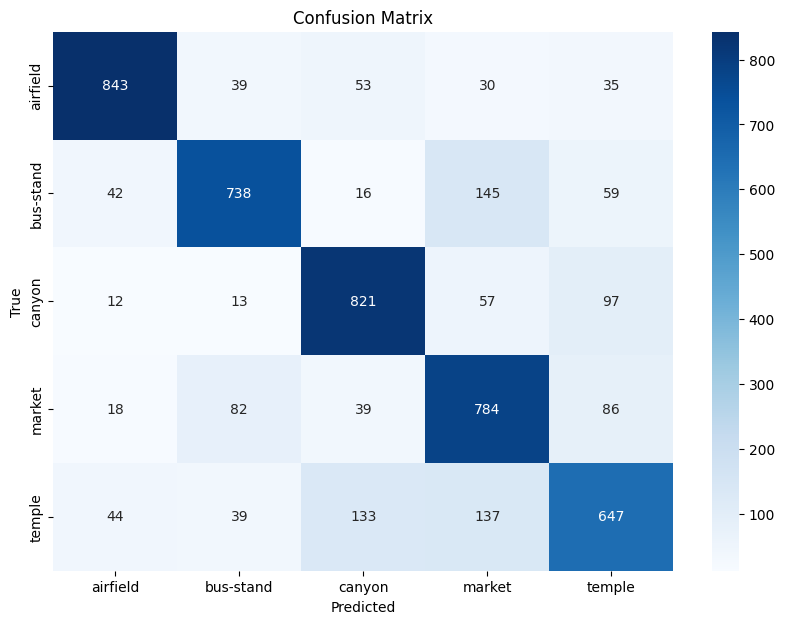

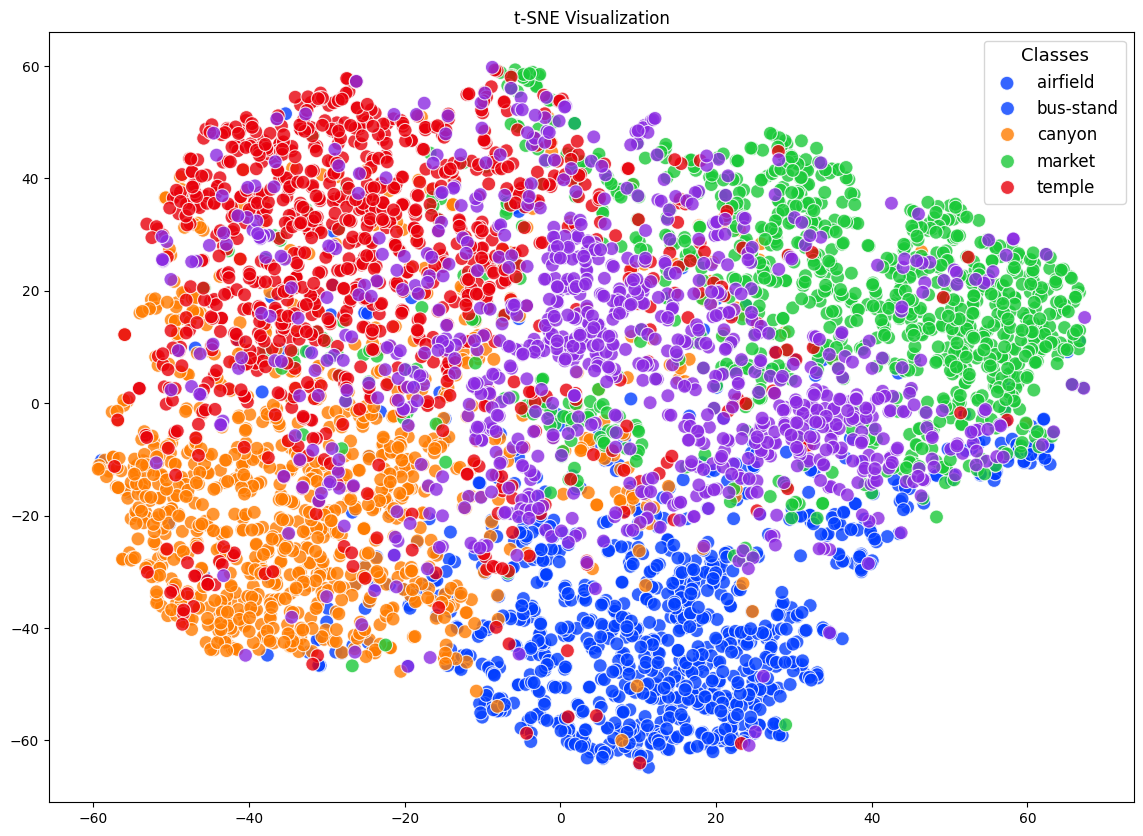

In [ ]:
# Load the saved model
from sklearn.manifold import TSNE
saved_model_path = '/content/drive/MyDrive/Dataset/best_model_20240615_101908.pth'
num_filters = 32
kernel_size = 5
dropout_rate = 0.0
num_units1 = 64
num_units2 = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_filters, kernel_size, dropout_rate, num_units1, num_units2).to(device)
model.load_state_dict(torch.load(saved_model_path, map_location=device))

# Load data
root_dir = "/content/drive/MyDrive/Dataset"
batch_size = 32
train_loader, test_loader, validation_loader, class_names = load_data(root_dir, batch_size)

# Evaluate on test set
test_accuracy = evaluate_model(model, test_loader, device)

# Get predictions and plot confusion matrix
test_preds, test_labels = get_predictions(model, test_loader, device)
cm = confusion_matrix(test_labels, test_preds)
plot_confusion_matrix(cm, class_names, 'confusion_matrix2.png')
plot_tsne(model, test_loader, class_names, device)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')
f1 = f1_score(test_labels, test_preds, average='weighted')
print(f'Accuracy: {test_accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Accuracy: 0.7652225993212218
Precision: 0.7683191426685542
Recall: 0.7652225993212218
F1-Score: 0.7653557169375538


<ipython-input-34-a11f573dd0af>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)  # 'tab10' colormap with 10 distinct colors


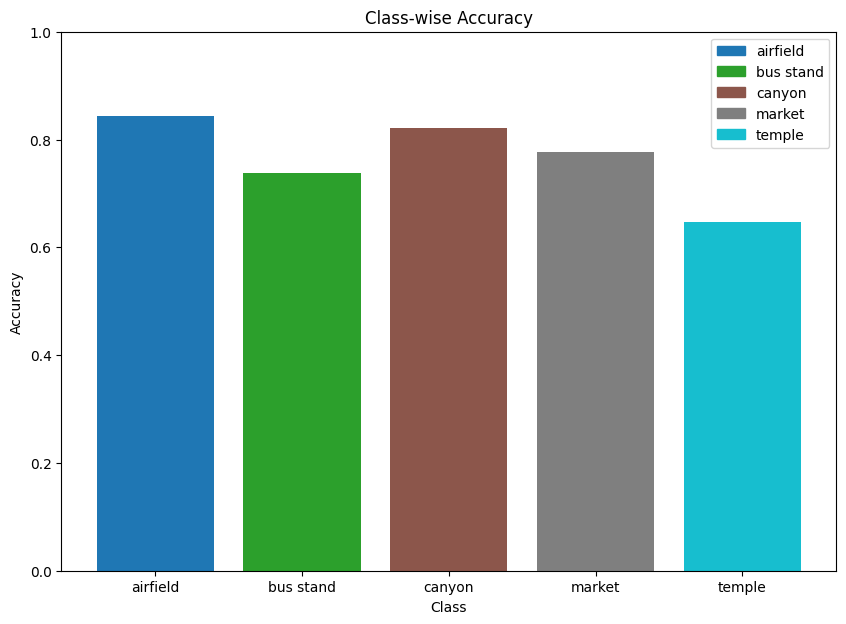

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_wise_accuracy(cm, class_names, save_path):
    class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

    # Define a color palette with enough colors for all classes
    num_classes = len(class_names)
    colors = plt.cm.get_cmap('tab10', num_classes)  # 'tab10' colormap with 10 distinct colors

    plt.figure(figsize=(10, 7))
    bars = plt.bar(class_names, class_wise_accuracy, color=colors(np.arange(num_classes)))

    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Class-wise Accuracy')
    plt.ylim(0, 1)

    # Create custom legend with colored patches
    legend_patches = [plt.Rectangle((0,0),1,1, color=colors(i)) for i in range(num_classes)]
    plt.legend(legend_patches, class_names, loc='best')

    plt.savefig(save_path)
    plt.show()
    plt.close()

plot_class_wise_accuracy(cm, class_names, 'class_wise_accuracy.png')


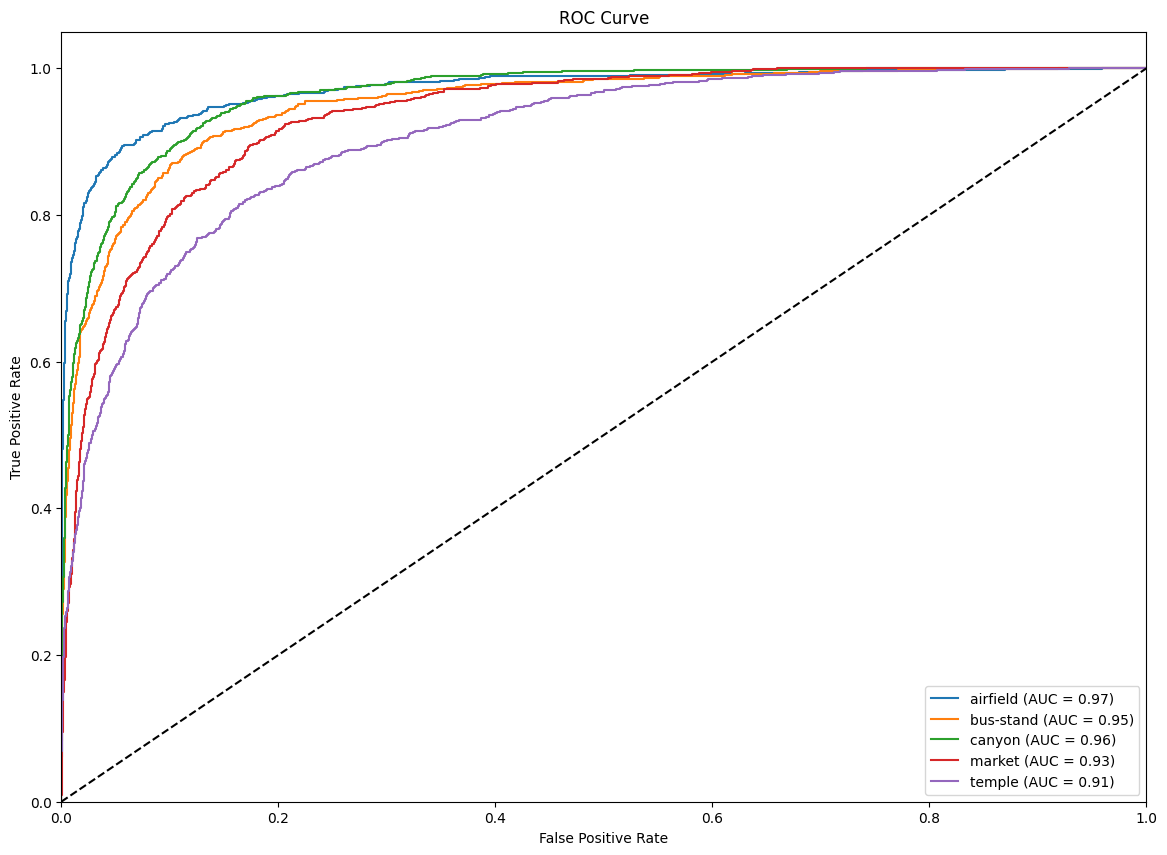

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
def plot_roc_auc(model, data_loader, class_names, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_labels = label_binarize(all_labels, classes=range(len(class_names)))

    plt.figure(figsize=(14, 10))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(all_labels[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig('roc_auc.png')
    plt.show()

# Plot ROC AUC
plot_roc_auc(model, test_loader, class_names, device)

In [ ]:
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=30752, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=5, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)
